Ivan<br>
27/12/2023

# Example Dashboard

## Generate polygons to fill under 3D line graph

Demonstrate how to create polygons which fill the space under a line graph. In this example polygons are semi-transparent, creating a sort of 'jagged stained glass' effect.

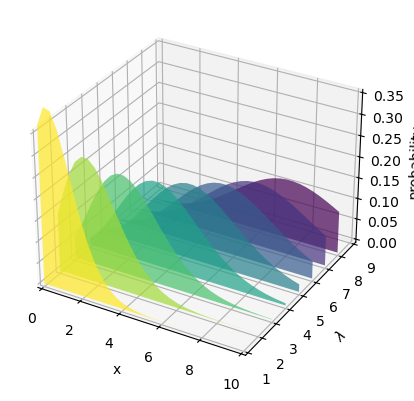

In [10]:
import math

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import PolyCollection

# Fixing random state for reproducibility
np.random.seed(19680801)


def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]


ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(0., 10., 31)
lambdas = range(1, 9)

# verts[i] is a list of (x, y) pairs defining polygon i.
gamma = np.vectorize(math.gamma)
verts = [polygon_under_graph(x, l**x * np.exp(-l) / gamma(x + 1))
         for l in lambdas]
facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))

poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=lambdas, zdir='y')

ax.set(xlim=(0, 10), ylim=(1, 9), zlim=(0, 0.35),
       xlabel='x', ylabel=r'$\lambda$', zlabel='probability')

plt.show()

## Time Series Histogram

This example demonstrates how to efficiently visualize large numbers of time series in a way that could potentially reveal hidden substructure and patterns that are not immediately obvious, and display them in a visually appealing way.

In this example, we generate multiple sinusoidal "signal" series that are buried under a larger number of random walk "noise/background" series. For an unbiased Gaussian random walk with standard deviation of σ, the RMS deviation from the origin after n steps is σ*sqrt(n). So in order to keep the sinusoids visible on the same scale as the random walks, we scale the amplitude by the random walk RMS. In addition, we also introduce a small random offset `phi` to shift the sines left/right, and some additive random noise to shift individual data points up/down to make the signal a bit more "realistic" (you wouldn't expect a perfect sine wave to appear in your data).

The first plot shows the typical way of visualizing multiple time series by overlaying them on top of each other with `plt.plot` and a small value of `alpha`. The second and third plots show how to reinterpret the data as a 2d histogram, with optional interpolation between data points, by using `np.histogram2d` and `plt.pcolormesh`.

0.267 sec. elapsed
0.122 sec. elapsed


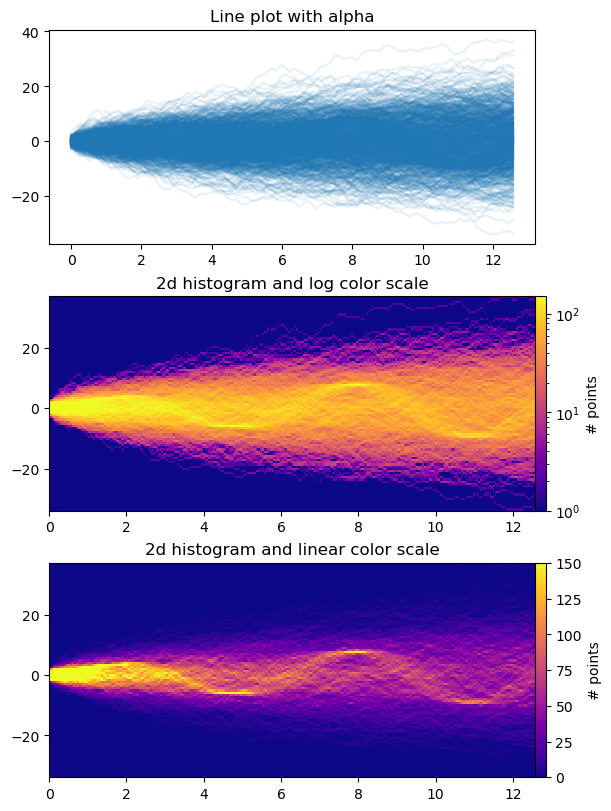

In [11]:
import time

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')

# Fix random state for reproducibility
np.random.seed(19680801)
# Make some data; a 1D random walk + small fraction of sine waves
num_series = 1000
num_points = 100
SNR = 0.10  # Signal to Noise Ratio
x = np.linspace(0, 4 * np.pi, num_points)
# Generate unbiased Gaussian random walks
Y = np.cumsum(np.random.randn(num_series, num_points), axis=-1)
# Generate sinusoidal signals
num_signal = round(SNR * num_series)
phi = (np.pi / 8) * np.random.randn(num_signal, 1)  # small random offset
Y[-num_signal:] = (
        np.sqrt(np.arange(num_points))  # random walk RMS scaling factor
        * (np.sin(x - phi)
           + 0.05 * np.random.randn(num_signal, num_points))  # small random noise
)


# Plot series using `plot` and a small value of `alpha`. With this view it is
# very difficult to observe the sinusoidal behavior because of how many
# overlapping series there are. It also takes a bit of time to run because so
# many individual artists need to be generated.
tic = time.time()
axes[0].plot(x, Y.T, color="C0", alpha=0.1)
toc = time.time()
axes[0].set_title("Line plot with alpha")
print(f"{toc-tic:.3f} sec. elapsed")


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
tic = time.time()
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.concatenate([np.interp(x_fine, x, y_row) for y_row in Y])
x_fine = np.broadcast_to(x_fine, (num_series, num_fine)).ravel()


# Plot (x, y) points in 2d histogram with log colorscale
# It is pretty evident that there is some kind of structure under the noise
# You can tune vmax to make signal more visible
cmap = plt.colormaps["plasma"]
cmap = cmap.with_extremes(bad=cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm="log", vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")

toc = time.time()
print(f"{toc-tic:.3f} sec. elapsed")
plt.show()

## MRI with EEG

Displays a set of subplots with an MRI image, its intensity histogram and some EEG traces.

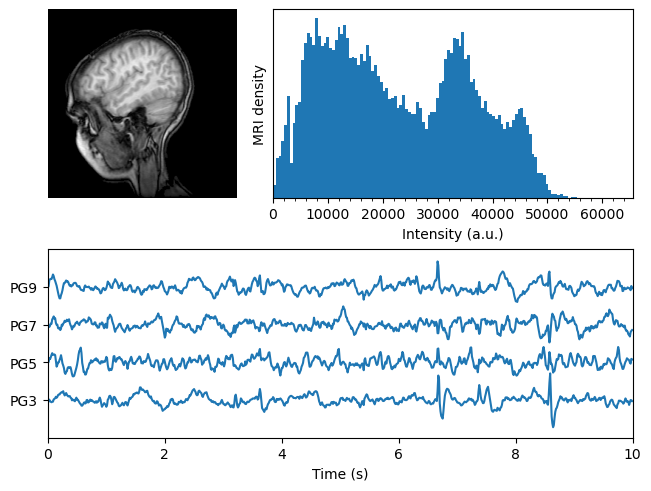

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cbook as cbook

fig, axd = plt.subplot_mosaic(
    [["image", "density"],
     ["EEG", "EEG"]],
    layout="constrained",
    # "image" will contain a square image. We fine-tune the width so that
    # there is no excess horizontal or vertical margin around the image.
    width_ratios=[1.05, 2],
)

# Load the MRI data (256x256 16-bit integers)
with cbook.get_sample_data('s1045.ima.gz') as dfile:
    im = np.frombuffer(dfile.read(), np.uint16).reshape((256, 256))

# Plot the MRI image
axd["image"].imshow(im, cmap="gray")
axd["image"].axis('off')

# Plot the histogram of MRI intensity
im = im[im.nonzero()]  # Ignore the background
axd["density"].hist(im, bins=np.arange(0, 2**16+1, 512))
axd["density"].set(xlabel='Intensity (a.u.)', xlim=(0, 2**16),
                   ylabel='MRI density', yticks=[])
axd["density"].minorticks_on()

# Load the EEG data
n_samples, n_rows = 800, 4
with cbook.get_sample_data('eeg.dat') as eegfile:
    data = np.fromfile(eegfile, dtype=float).reshape((n_samples, n_rows))
t = 10 * np.arange(n_samples) / n_samples

# Plot the EEG
axd["EEG"].set_xlabel('Time (s)')
axd["EEG"].set_xlim(0, 10)
dy = (data.min() - data.max()) * 0.7  # Crowd them a bit.
axd["EEG"].set_ylim(-dy, n_rows * dy)
axd["EEG"].set_yticks([0, dy, 2*dy, 3*dy], labels=['PG3', 'PG5', 'PG7', 'PG9'])

for i, data_col in enumerate(data.T):
    axd["EEG"].plot(t, data_col + i*dy, color="C0")

plt.show()